In [41]:
"""
use this notebook to make the secondary signal processing code (applying cuts to the data)

Cuts:



CSV has columns 0 to 12:
(index column)
column 0: baseline
column 1: sd_baseline
column 2: amplitude
column 3: peak_time
column 4: FWHM
column 5: t1_of_FWHM
column 6: t2_of_FWHM
column 7: time_above_3sigma
column 8: first_3sigma_crossing
column 9: second_3sigma_crossing
column 10: integral_pC
column 11: peaks_over_15sigma_threshold
column 12: event_timestamps

"""

'\nuse this notebook to make the secondary signal processing code (applying cuts to the data)\n\nCuts:\n\n\n\nCSV has columns 0 to 12:\n(index column)\ncolumn 0: baseline\ncolumn 1: sd_baseline\ncolumn 2: amplitude\ncolumn 3: peak_time\ncolumn 4: FWHM\ncolumn 5: t1_of_FWHM\ncolumn 6: t2_of_FWHM\ncolumn 7: time_above_3sigma\ncolumn 8: first_3sigma_crossing\ncolumn 9: second_3sigma_crossing\ncolumn 10: integral_pC\ncolumn 11: peaks_over_15sigma_threshold\ncolumn 12: event_timestamps\n\n'

In [42]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from scipy.special import gamma
import os
from os.path import exists
import matplotlib.colors as mcolors

#file being read in
df = pd.read_csv('PMT7_Processed_moresig/020226_darkrate_1800_10000_1_off_processed_threshold27.csv')
#df = pd.read_csv('Processed15Sigma/131125_darkrate_1800_10000_2_on_processed_threshold15.csv')

#file being outputted
cleaned_data_filename = 'DarkRateVaryingVProcessed/141125_darkrate_2000_10000_1_off_processed.csv'
folder_name = "DarkRateVaryingVClean"
file_path = os.path.join(os.getcwd(), folder_name, cleaned_data_filename)

#change based on needs/experiment
v_window_size = (-25e-3, 225e-3) #remember that the y-axis is flipped so pulse is positive
tolerance = 5e-4 #discard any events which come within 1mV of the window edge

#make data frame for cleaned data
cleaned_baseline_df = df.copy()
cleaned_thresh_df = df.copy()
cleaned_TTabove_df = df.copy()
cleaned_VinLast10_df = df.copy()

cleaned_df = df.copy()

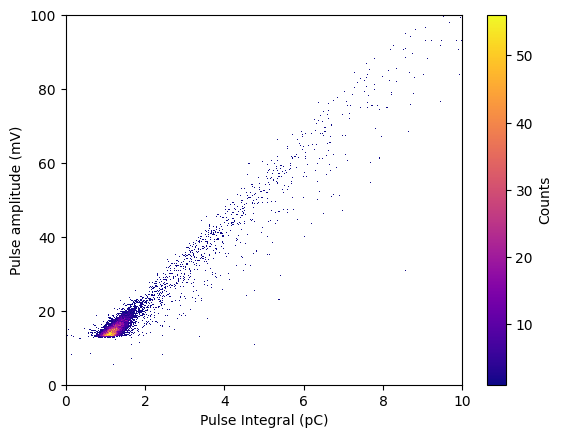

In [43]:
# plot 2d histogram of pulse amplitudes before cuts
amplitudes = df['amplitude'] * 1e3
pulse_integrals = df['integral_pC']

#plt.hist2d(pulse_integrals, amplitudes, bins=10, range=None, density=False)
h = plt.hist2d(
    pulse_integrals, 
    amplitudes, 
    bins=1000,           # finer resolution
    density=False, 
    cmap='plasma',     # nicer color map
    cmin=1
    
)
plt.ylabel('Pulse amplitude (mV)')
plt.xlabel('Pulse Integral (pC)')
plt.colorbar(h[3], label='Counts')  # colorbar
plt.xlim([0, 10])
plt.ylim([0, 100])
plt.show()

In [44]:
print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

amount of events removed: 0
number of events in cleaned data frame: 10000


<>:80: SyntaxWarning: invalid escape sequence '\m'
<>:80: SyntaxWarning: invalid escape sequence '\m'
C:\Users\holly\AppData\Local\Temp\ipykernel_53648\1992792034.py:80: SyntaxWarning: invalid escape sequence '\m'
  plt.axvline((mu_sb +15*sigma_sb), color='g', linestyle=':', label='Value of $\mu$ + $15\sigma$')


Fit completed max 3 iterations.


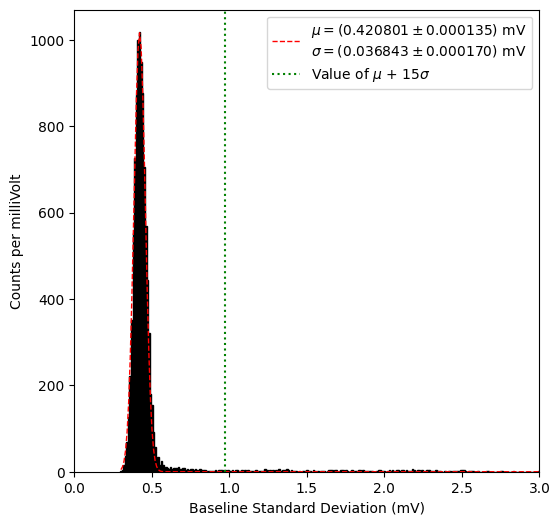

amount of events removed: 328
number of events in cleaned data frame: 9672


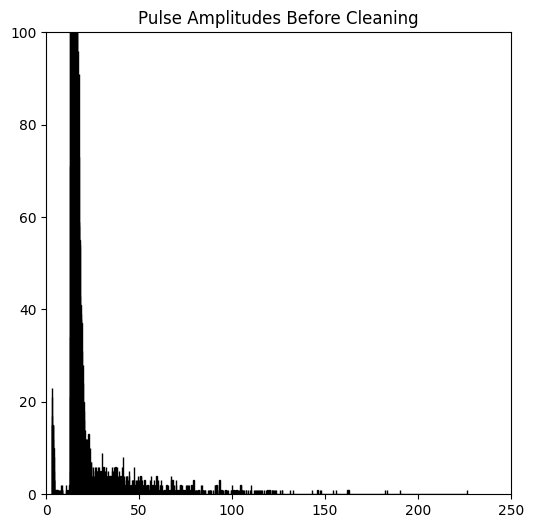

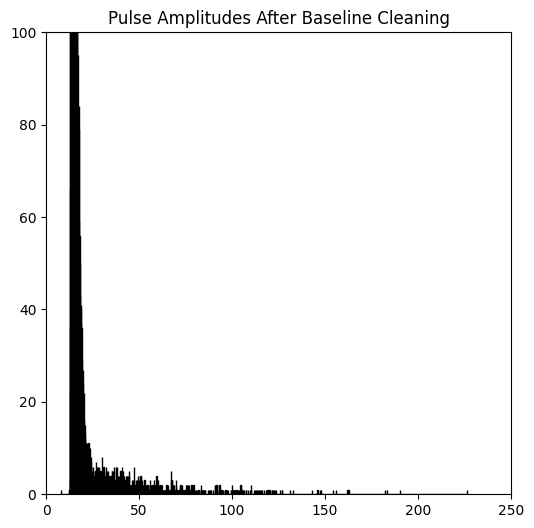

In [45]:
# Cut data based on baseline only

# histogram and gaussian for baseline standard deviations
plt.figure(figsize=(6, 6))
sigma_b_array_mV = df['sd_baseline'].to_numpy() * 1e3

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.01) #chosen 1 bin = 0.01mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='black', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    mu_sb = final_popt[1]
    sigma_sb = final_popt[2]
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1, label=[
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_sb, err_mu, sigma_sb, err_sigma)])
    plt.xlim(0, 3)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per milliVolt')
    plt.axvline((mu_sb +15*sigma_sb), color='g', linestyle=':', label='Value of $\mu$ + $15\sigma$')
    #plt.legend([
    #r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    #'\n'                                              # Newline character
    #r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
     #   mu_sb, err_mu, sigma_sb, err_sigma)], loc='best', fontsize=10)
    plt.legend(loc='best', fontsize=10)
    
    plt.show()


good_sigma = cleaned_baseline_df['sd_baseline'] < ((mu_sb +15*sigma_sb) * 1e-3)
cleaned_baseline_df = cleaned_baseline_df[good_sigma]

print('amount of events removed:', len(df)-len(cleaned_baseline_df))
print('number of events in cleaned data frame:', len(cleaned_baseline_df))

plt.figure(figsize=(6, 6))
all_amplitudes_mV = df['amplitude'].to_numpy() * 1e3

def gaussian_amp(all_amplitudes_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_amplitudes_mV - mu)**2)/ sigma**2)

amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.ylim(0, 100)
plt.xlim(0,250)
plt.title('Pulse Amplitudes Before Cleaning')
plt.show()

plt.figure(figsize=(6, 6))
all_amplitudes_mV = cleaned_baseline_df['amplitude'].to_numpy() * 1e3

def gaussian_amp(all_amplitudes_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_amplitudes_mV - mu)**2)/ sigma**2)

amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.ylim(0, 100)
plt.xlim(0,250)
plt.title('Pulse Amplitudes After Baseline Cleaning')
plt.show()


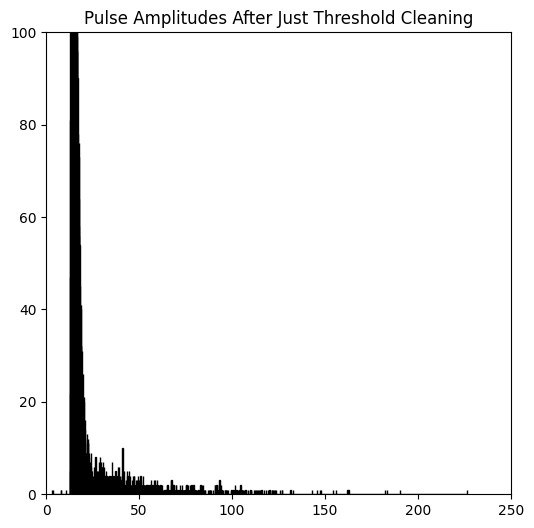

amount of events removed: 593
number of events in cleaned data frame: 9407
Fit completed max 3 iterations.


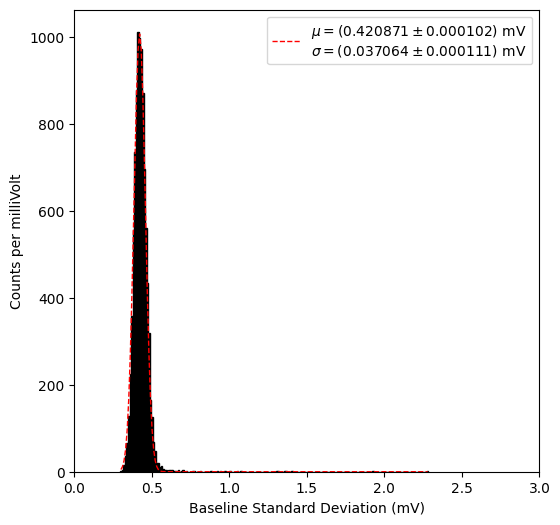

In [46]:
# Clean based on whether the pulse crosses the threshold put in place

sigma_thresh = df["time_above_threshold"] > 0 # input only events that cross threshold
cleaned_thresh_df = cleaned_thresh_df[sigma_thresh]

plt.figure(figsize=(6, 6))
all_amplitudes_mV = cleaned_thresh_df['amplitude'].to_numpy() * 1e3

def gaussian_amp(all_amplitudes_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_amplitudes_mV - mu)**2)/ sigma**2)

amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.ylim(0, 100)
plt.xlim(0,250)
plt.title('Pulse Amplitudes After Just Threshold Cleaning')
plt.show()


print('amount of events removed:', len(df)-len(cleaned_thresh_df))
print('number of events in cleaned data frame:', len(cleaned_thresh_df))

plt.figure(figsize=(6, 6))
sigma_b_array_mV = cleaned_thresh_df['sd_baseline'].to_numpy() * 1e3

def gaussian_sb(sigma_b_array_mV, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (sigma_b_array_mV - mu)**2)/ sigma**2)

sb_number_of_bins = int((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV))/0.01) #chosen 1 bin = 0.01mV
#print((np.max(sigma_b_array_mV)-np.min(sigma_b_array_mV)))
n, bins, patches = plt.hist(sigma_b_array_mV, bins=sb_number_of_bins, color='black', edgecolor='black')
bin_centers = 0.5 * (bins[1:] + bins[:-1])

MAX_ITERATIONS = 3
SIGMA_THRESHOLD = 3.0  # Remove points > 3 standard deviations away

fit_mask = (bin_centers >=0) & (bin_centers <=2)
bin_centers_filtered = bin_centers[fit_mask]
n_filtered = n[fit_mask]

X_fit = bin_centers_filtered.copy()
Y_fit = n_filtered.copy()
p0 = [np.max(n_filtered), np.mean(bin_centers_filtered), np.std(bin_centers_filtered)]

final_popt = None
final_pcov = None
final_mask = None

for i in range(MAX_ITERATIONS):
    try:
        # 1. Fit the current data
        popt, pcov = curve_fit(gaussian_sb, X_fit, Y_fit, p0=p0)
        # store results
        final_popt = popt
        final_pcov = pcov
        # 2. Calculate the fitted curve and residuals
        Y_fitted = gaussian_sb(X_fit, *popt)
        residuals = Y_fit - Y_fitted
        # 3. Calculate the standard deviation of the residuals (a measure of fit scatter)
        residual_std = np.std(residuals)
        
        # 4. Create a mask to identify outliers
        mask = np.abs(residuals) < (SIGMA_THRESHOLD * residual_std)
        
        # If no points are removed, the process is stable; stop
        if np.all(mask):
            print(f"Converged after {i+1} iterations.")
            break
            
        # 5. Apply the mask to remove outliers for the next iteration
        X_fit = X_fit[mask]
        Y_fit = Y_fit[mask]
        
        # Update the initial guess (p0) for the next iteration with the current fit
        p0 = popt
        
    except RuntimeError:
        print(f"Fit failed during iteration {i+1}. Stopping.")
        break
else:
    print(f"Fit completed max {MAX_ITERATIONS} iterations.")
# calculate final errors and plot
if final_popt is None:
    print("Error: No successful fit achieved.")
else:
    sb_fit_full = gaussian_sb(bin_centers, *final_popt)
    mu_sb = final_popt[1]
    sigma_sb = final_popt[2]
    err_mu = np.sqrt(final_pcov[1,1])
    err_sigma = np.sqrt(final_pcov[2,2])
    plt.plot(bin_centers, sb_fit_full, 'r--', linewidth=1, label=[
    r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    '\n'                                              # Newline character
    r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
        mu_sb, err_mu, sigma_sb, err_sigma)])
    plt.xlim(0, 3)
    plt.xlabel('Baseline Standard Deviation (mV)')
    plt.ylabel('Counts per milliVolt')
    #plt.axvline((mu_sb +15*sigma_sb), color='g', linestyle=':', label='Value of $\mu$ + $15\sigma$')
    #plt.legend([
    #r'$\mu=(%.6f \pm %.6f)\ \mathrm{mV}$'  # First line: Mean ($\mu$)
    #'\n'                                              # Newline character
    #r'$\sigma=(%.6f \pm %.6f)\ \mathrm{mV}$' % (        # Second line: Std Dev ($\sigma$)
     #   mu_sb, err_mu, sigma_sb, err_sigma)], loc='best', fontsize=10)
    plt.legend(loc='best', fontsize=10)
    
    plt.show()


In [47]:
good_time = df['total_time_above'] < 2e-8
cleaned_TTabove_df = cleaned_TTabove_df[good_time]

print('amount of events removed:', len(df)-len(cleaned_TTabove_df))
print('number of events in cleaned data frame:', len(cleaned_TTabove_df))

good_voltage = df['value_at_end'] < 1
cleaned_VinLast10_df = cleaned_VinLast10_df[good_voltage]

print('amount of events removed:', len(df)-len(cleaned_VinLast10_df))
print('number of events in cleaned data frame:', len(cleaned_VinLast10_df))


amount of events removed: 594
number of events in cleaned data frame: 9406
amount of events removed: 13
number of events in cleaned data frame: 9987


In [48]:

#15sigma threshold clean
sigma_thresh = cleaned_df["time_above_threshold"] > 0 #keep events which cross the threshold
cleaned_df = cleaned_df[sigma_thresh]

good_time = cleaned_df['total_time_above'] < 2e-8
cleaned_df = cleaned_df[good_time]

good_voltage = cleaned_df['value_at_end'] < 1
cleaned_df = cleaned_df[good_voltage]

amplitude_cut = cleaned_df["amplitude"] > 14e-3
cleaned_df = cleaned_df[amplitude_cut]

print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

amount of events removed: 3041
number of events in cleaned data frame: 6959


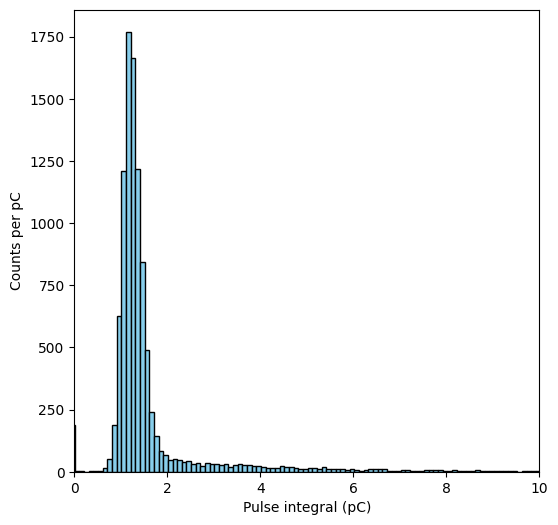

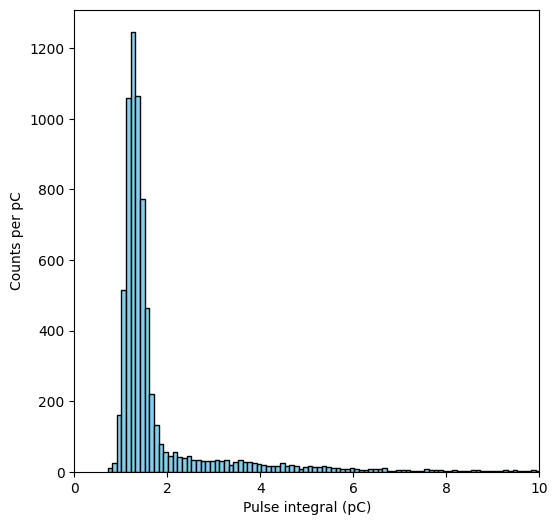

In [49]:

plt.figure(figsize=(6, 6))
all_integrals_picocharge = df['integral_pC'].to_numpy()


def gaussian_pulse(all_integrals_picocharge, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_integrals_picocharge - mu)**2)/ sigma**2)
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
n, bins, patches = plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color = 'skyblue', edgecolor = 'black')

plt.xlim([0,10])
plt.xlabel('Pulse integral (pC)')
plt.ylabel('Counts per pC')
plt.show()

plt.figure(figsize=(6, 6))
all_integrals_picocharge = cleaned_df['integral_pC'].to_numpy()


def gaussian_pulse(all_integrals_picocharge, amp,  mu, sigma):
    return amp * (1 / (sigma * np.sqrt(2 * np.pi))) * np.exp((-0.5 * (all_integrals_picocharge - mu)**2)/ sigma**2)
int_number_of_bins = int((np.max(all_integrals_picocharge)-np.min(all_integrals_picocharge))/0.1) #chosen 1 bin = 0.1 pC
n, bins, patches = plt.hist(all_integrals_picocharge, bins=int_number_of_bins, color = 'skyblue', edgecolor = 'black')

plt.xlim([0,10])
plt.xlabel('Pulse integral (pC)')
plt.ylabel('Counts per pC')
plt.show()



Text(0, 0.5, 'Counts per milliVolt')

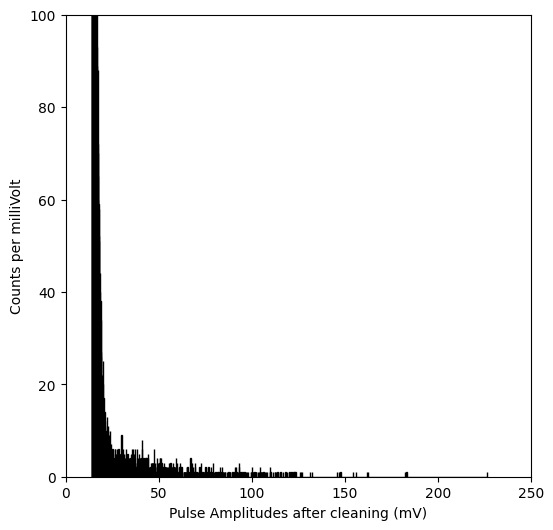

In [50]:
#have a look at the data plots after cleaning!


# histogram for Peak Amplitudes
plt.figure(figsize=(6, 6))
all_amplitudes_mV = cleaned_df['amplitude'].to_numpy() * 1e3
amp_number_of_bins = int((np.max(all_amplitudes_mV)-np.min(all_amplitudes_mV))/0.1) #chosen 1 bin = 0.1mV
plt.hist(all_amplitudes_mV, bins=amp_number_of_bins, color='skyblue', edgecolor='black')
plt.xlim(0,250)
plt.ylim(0,100)
plt.xlabel('Pulse Amplitudes after cleaning (mV)')
plt.ylabel('Counts per milliVolt')
#plt.show()



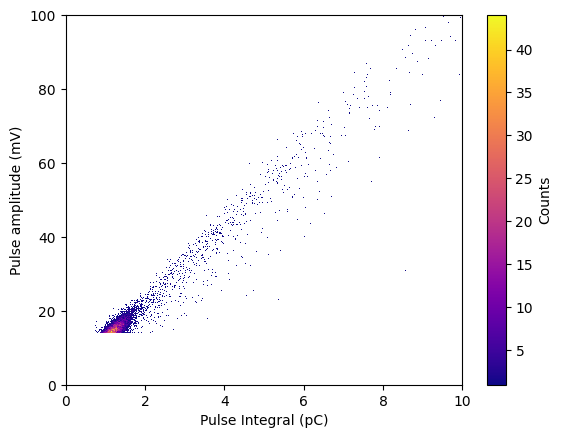

In [51]:
amplitudes = cleaned_df['amplitude'] * 1e3
pulse_integrals = cleaned_df['integral_pC']

#plt.hist2d(pulse_integrals, amplitudes, bins=10, range=None, density=False)
h = plt.hist2d(
    pulse_integrals, 
    amplitudes, 
    bins=1000,           # finer resolution
    density=False, 
    cmap='plasma',
    cmin=1,     # nicer color map
)
plt.ylabel('Pulse amplitude (mV)')
plt.xlabel('Pulse Integral (pC)')
plt.colorbar(h[3], label='Counts')  # colorbar
plt.xlim([0, 10])
plt.ylim([0, 100])
#plt.ylim([np.min(amplitudes), 80])
plt.show()

In [52]:
#export the cleaned data to another csv

#cleaned_df.to_csv(file_path, sep=',', encoding='utf-8-sig', index=True, header=True)


In [53]:
print('amount of events removed:', len(df)-len(cleaned_df))
print('number of events in cleaned data frame:', len(cleaned_df))

amount of events removed: 3041
number of events in cleaned data frame: 6959
